<a href="https://colab.research.google.com/github/sjamillah/Sound_clustering/blob/main/Audio_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Brief Introduction

This project introduces us to the exciting and under-explored domain of unsupervised learning with audio. Instead of manipulating clean labeled sounds, we handle unprocessed, unlabeled audio files—like those you would find in a messy music library or a field recording full of background noise—and try to derive meaning from them. Using powerful clustering techniques, we uncover hidden patterns and cluster similar sounds automatically, without knowing ahead of time what the sounds are. It's kind of like teaching a computer how to listen and organize audio that a human would—by identifying similarity in rhythm, pitch, or texture. This kind of work mimics real-world scenarios where a large amount of data is available but no categories beforehand, such as classifying environmental noise, or categorizing music based on mood or genre, or simply looking for patterns of speech when conducting language analysis.

## Importation of the libraries and setup of the environment

I begin by importing the essential libraries for our audio clustering analysis:
- **Audio Processing**: librosa for advanced audio feature extraction
- **Machine Learning**: scikit-learn for clustering algorithms and dimensionality reduction
- **Data Manipulation**: pandas and numpy for data handling and numerical operations
- **Visualization**: matplotlib and seaborn for creating insightful plots
- **Google Colab Integration**: drive mounting for accessing our audio dataset

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import librosa
import librosa.display
import os
from google.colab import drive

In [24]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [25]:
class Config:
    """Configuration parameters for the clustering pipeline"""
    # Audio processing
    N_MELS = 128
    N_FFT = 2048
    HOP_LENGTH = 512
    FMAX = 8000

    # Clustering
    OPTIMAL_K = 3
    TARGET_NOISE_RATIO = 0.15

    # Visualization
    FIGSIZE_DEFAULT = (10, 8)
    FIGSIZE_3D = (12, 10)
    FIGSIZE_COMPARISON = (18, 6)

## Google Drive Mount
I first had to mount the Google Drive inorder to access the dataset stored in it inorder to interact with the data afterwards.

In [26]:
def mount_drive(unlabelled_data_path='/content/drive'):
  """
  Setup of the Google Drive mount with directory creation
  """
  if not os.path.exists(unlabelled_data_path):
    os.makedirs(unlabelled_data_path)
  drive.mount(unlabelled_data_path)

mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Extraction
To get the audio data into a format I can work with machine learning on, I needed to extract meaningful features from raw sound files. On their own, they're just long strings of amplitudes across time—something that a model can't instantly understand. I needed something to process that raw data into a more abstract and condensed format.

### Why I Chose Mel Spectrogram Features
I have used Mel Spectrograms because they provide a rich time-frequency representation that captures both spectral content and temporal evolution of audio signals. Mel Spectrograms utilize the mel scale to emphasize frequencies important to human hearing while preserving the detailed frequency information across time. I used them because:
- They maintain both frequency and time information unlike compressed features
- They're highly effective for capturing musical and tonal characteristics
- They provide a good balance between information richness and computational efficiency
- They form the foundation for many modern audio analysis techniques

### My Feature Extraction Process
For each audio clip, I extracted Mel Spectrograms with 128 mel frequency bands. Then, to make the features manageable for clustering, I calculated comprehensive statistical measures including mean, standard deviation, maximum, minimum, median, and percentiles of those spectrograms across time. Additionally, I computed global spectral characteristics like spectral centroid, spread, and rolloff. This yielded a rich feature set that captures both local frequency characteristics and global spectral properties of each audio clip.

In [27]:
def extract_features(audio_files, n_mels=128, n_fft=2048, hop_length=512, fmax=8000):
  """
  Extract Mel Spectrogram features from the audio files

  Args:
    audio_files (list): list of audio file paths
    n_mels (int): number of mel frequency bands to extract
    n_fft (int): FFT window size
    hop_length (int): hop length for STFT
    fmax (float): maximum frequency

  Returns:
    pd.DataFrame: DataFrame containing the extracted features
  """
  features = []
  file_info = []
  failed_files = []

  print(f"Extracting Mel Spectrogram features from {len(audio_files)} files...")
  print(f"Parameters: n_mels={n_mels}, n_fft={n_fft}, hop_length={hop_length}")

  for i, audio_file in enumerate(audio_files):
    try:
      # Load audio file
      y, sr = librosa.load(audio_file, sr=None)

      # Extract Mel Spectrogram
      mel_spec = librosa.feature.melspectrogram(
          y=y,
          sr=sr,
          n_mels=n_mels,
          n_fft=n_fft,
          hop_length=hop_length,
          fmax=fmax
      )

      # Convert to log scale (dB)
      mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

      # Extract comprehensive statistical features
      feature_vector = []

      # Statistics across time dimension for each mel band
      feature_vector.extend(np.mean(mel_spec_db, axis=1))      # Mean of each mel band
      feature_vector.extend(np.std(mel_spec_db, axis=1))       # Std of each mel band
      feature_vector.extend(np.max(mel_spec_db, axis=1))       # Max of each mel band
      feature_vector.extend(np.min(mel_spec_db, axis=1))       # Min of each mel band
      feature_vector.extend(np.median(mel_spec_db, axis=1))    # Median of each mel band
      feature_vector.extend(np.percentile(mel_spec_db, 25, axis=1))  # 25th percentile
      feature_vector.extend(np.percentile(mel_spec_db, 75, axis=1))  # 75th percentile

      # Global spectral features
      spectral_centroid = np.mean(np.sum(mel_spec_db * np.arange(mel_spec_db.shape[0])[:, np.newaxis], axis=0) /
                                 (np.sum(mel_spec_db, axis=0) + 1e-8))
      spectral_spread = np.std(mel_spec_db, axis=0).mean()
      spectral_rolloff = np.percentile(mel_spec_db, 95, axis=0).mean()

      feature_vector.extend([spectral_centroid, spectral_spread, spectral_rolloff])

      features.append(feature_vector)

      file_info.append({
          'file': os.path.basename(audio_file),
          'duration': len(y) / sr,
          'sample_rate': sr
      })

      # Progress indicator
      if (i + 1) % 10 == 0:
          print(f"Processed {i + 1}/{len(audio_files)} files")

    except Exception as e:
      print(f"Error processing {audio_file}: {e}")
      failed_files.append(audio_file)

  print(f"\nFeature extraction completed!")
  print(f"Successfully processed: {len(features)} files")
  print(f"Failed: {len(failed_files)} files")

  # Create feature names
  feature_names = []
  stats = ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75']
  for stat in stats:
      for i in range(n_mels):
          feature_names.append(f'mel_{i}_{stat}')
  feature_names.extend(['spectral_centroid', 'spectral_spread', 'spectral_rolloff'])

  # Convert to DataFrame
  features_df = pd.DataFrame(features, columns=feature_names)

  return features_df

# Loading and Extraction of the features
unlabelled_data_path = '/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds'
audio_files = [os.path.join(unlabelled_data_path, f)
                for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]
features_df = extract_features(audio_files)
print(f"Extracted features for {len(audio_files)} audio files.")
print(f"Feature matrix shape: {features_df.shape}")
display(features_df.head())

Extracting Mel Spectrogram features from 3000 files...
Parameters: n_mels=128, n_fft=2048, hop_length=512


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processed 10/3000 files
Processed 20/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1434
  warnings.warn(


Processed 30/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1824
  warnings.warn(


Processed 40/3000 files
Processed 50/3000 files
Processed 60/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1440
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1790
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(


Processed 70/3000 files
Processed 80/3000 files
Processed 90/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(


Processed 100/3000 files
Processed 110/3000 files
Processed 120/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(


Processed 130/3000 files
Processed 140/3000 files
Processed 150/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(


Processed 160/3000 files
Processed 170/3000 files
Processed 180/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1915
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1854
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2012
  warnings.warn(


Processed 190/3000 files
Processed 200/3000 files
Processed 210/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1960
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1475
  warnings.warn(


Processed 220/3000 files
Processed 230/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(


Processed 240/3000 files
Processed 250/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1610
  warnings.warn(


Processed 260/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(


Processed 270/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(


Processed 280/3000 files
Processed 290/3000 files
Processed 300/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1914
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1962
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1830
  warnings.warn(


Processed 310/3000 files
Processed 320/3000 files
Processed 330/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1295
  warnings.warn(


Processed 340/3000 files
Processed 350/3000 files
Processed 360/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(


Processed 370/3000 files
Processed 380/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(


Processed 390/3000 files
Processed 400/3000 files
Processed 410/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1900
  warnings.warn(


Processed 420/3000 files
Processed 430/3000 files
Processed 440/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1903
  warnings.warn(


Processed 450/3000 files
Processed 460/3000 files
Processed 470/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1713
  warnings.warn(


Processed 480/3000 files
Processed 490/3000 files
Processed 500/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1973
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2044
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2016
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1650
  warnings.warn(


Processed 510/3000 files
Processed 520/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2039
  warnings.warn(


Processed 530/3000 files
Processed 540/3000 files
Processed 550/3000 files
Processed 560/3000 files
Processed 570/3000 files
Processed 580/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1525
  warnings.warn(


Processed 590/3000 files
Processed 600/3000 files
Processed 610/3000 files
Processed 620/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1997
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2005
  warnings.warn(


Processed 630/3000 files
Processed 640/3000 files
Processed 650/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1819
  warnings.warn(


Processed 660/3000 files
Processed 670/3000 files
Processed 680/3000 files
Processed 690/3000 files
Processed 700/3000 files
Processed 710/3000 files
Processed 720/3000 files
Processed 730/3000 files
Processed 740/3000 files
Processed 750/3000 files
Processed 760/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(


Processed 770/3000 files
Processed 780/3000 files
Processed 790/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(


Processed 800/3000 files
Processed 810/3000 files
Processed 820/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2001
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1450
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2034
  warnings.warn(


Processed 830/3000 files
Processed 840/3000 files
Processed 850/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1296
  warnings.warn(


Processed 860/3000 files
Processed 870/3000 files
Processed 880/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1357
  warnings.warn(


Processed 890/3000 files
Processed 900/3000 files
Processed 910/3000 files
Processed 920/3000 files
Processed 930/3000 files
Processed 940/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1149
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1919
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(


Processed 950/3000 files
Processed 960/3000 files
Processed 970/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1593
  warnings.warn(


Processed 980/3000 files
Processed 990/3000 files
Processed 1000/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1568
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1640
  warnings.warn(


Processed 1010/3000 files
Processed 1020/3000 files
Processed 1030/3000 files
Processed 1040/3000 files
Processed 1050/3000 files
Processed 1060/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1565
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2043
  warnings.warn(


Processed 1070/3000 files
Processed 1080/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1639
  warnings.warn(


Processed 1090/3000 files
Processed 1100/3000 files
Processed 1110/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1910
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1998
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(


Processed 1120/3000 files
Processed 1130/3000 files
Processed 1140/3000 files
Processed 1150/3000 files
Processed 1160/3000 files
Processed 1170/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1943
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1288
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1803
  warnings.warn(


Processed 1180/3000 files
Processed 1190/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1906
  warnings.warn(


Processed 1200/3000 files
Processed 1210/3000 files
Processed 1220/3000 files
Processed 1230/3000 files
Processed 1240/3000 files
Processed 1250/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1892
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1868
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1795
  warnings.warn(


Processed 1260/3000 files
Processed 1270/3000 files
Processed 1280/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(


Processed 1290/3000 files
Processed 1300/3000 files
Processed 1310/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1302
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1813
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1880
  warnings.warn(


Processed 1320/3000 files
Processed 1330/3000 files
Processed 1340/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1774
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(


Processed 1350/3000 files
Processed 1360/3000 files
Processed 1370/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1502
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1541
  warnings.warn(


Processed 1380/3000 files
Processed 1390/3000 files
Processed 1400/3000 files
Processed 1410/3000 files
Processed 1420/3000 files
Processed 1430/3000 files
Processed 1440/3000 files
Processed 1450/3000 files
Processed 1460/3000 files
Processed 1470/3000 files
Processed 1480/3000 files
Processed 1490/3000 files
Processed 1500/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1958
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2027
  warnings.warn(


Processed 1510/3000 files
Processed 1520/3000 files
Processed 1530/3000 files
Processed 1540/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1843
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1597
  warnings.warn(


Processed 1550/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1542
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1722
  warnings.warn(


Processed 1560/3000 files
Processed 1570/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1785
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1838
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(


Processed 1580/3000 files
Processed 1590/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(


Processed 1600/3000 files
Processed 1610/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1788
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1763
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1749
  warnings.warn(


Processed 1620/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(


Processed 1630/3000 files
Processed 1640/3000 files
Processed 1650/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1609
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1833
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1801
  warnings.warn(


Processed 1660/3000 files
Processed 1670/3000 files
Processed 1680/3000 files
Processed 1690/3000 files
Processed 1700/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1359
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1710
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(


Processed 1710/3000 files
Processed 1720/3000 files
Processed 1730/3000 files
Processed 1740/3000 files
Processed 1750/3000 files
Processed 1760/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1433
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1294
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(


Processed 1770/3000 files
Processed 1780/3000 files
Processed 1790/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(


Processed 1800/3000 files
Processed 1810/3000 files
Processed 1820/3000 files
Processed 1830/3000 files
Processed 1840/3000 files
Processed 1850/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(


Processed 1860/3000 files
Processed 1870/3000 files
Processed 1880/3000 files
Processed 1890/3000 files
Processed 1900/3000 files
Processed 1910/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1259
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1251
  warnings.warn(


Processed 1920/3000 files
Processed 1930/3000 files
Processed 1940/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1911
  warnings.warn(


Processed 1950/3000 files
Processed 1960/3000 files
Processed 1970/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1567
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(


Processed 1980/3000 files
Processed 1990/3000 files
Processed 2000/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1970
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1850
  warnings.warn(


Processed 2010/3000 files
Processed 2020/3000 files
Processed 2030/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1873
  warnings.warn(


Processed 2040/3000 files
Processed 2050/3000 files
Processed 2060/3000 files
Processed 2070/3000 files
Processed 2080/3000 files
Processed 2090/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1978
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1381
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(


Processed 2100/3000 files
Processed 2110/3000 files
Processed 2120/3000 files
Processed 2130/3000 files
Processed 2140/3000 files
Processed 2150/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1772
  warnings.warn(


Processed 2160/3000 files
Processed 2170/3000 files
Processed 2180/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1712
  warnings.warn(


Processed 2190/3000 files
Processed 2200/3000 files
Processed 2210/3000 files
Processed 2220/3000 files
Processed 2230/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1988
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1443
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(


Processed 2240/3000 files
Processed 2250/3000 files
Processed 2260/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1697
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2015
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(


Processed 2270/3000 files
Processed 2280/3000 files
Processed 2290/3000 files
Processed 2300/3000 files
Processed 2310/3000 files
Processed 2320/3000 files
Processed 2330/3000 files
Processed 2340/3000 files
Processed 2350/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1682
  warnings.warn(


Processed 2360/3000 files
Processed 2370/3000 files
Processed 2380/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1870
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1556
  warnings.warn(


Processed 2390/3000 files
Processed 2400/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1781
  warnings.warn(


Processed 2410/3000 files
Processed 2420/3000 files
Processed 2430/3000 files
Processed 2440/3000 files
Processed 2450/3000 files
Processed 2460/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1664
  warnings.warn(


Processed 2470/3000 files
Processed 2480/3000 files
Processed 2490/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1148
  warnings.warn(


Processed 2500/3000 files
Processed 2510/3000 files
Processed 2520/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1560
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1632
  warnings.warn(


Processed 2530/3000 files
Processed 2540/3000 files
Processed 2550/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1807
  warnings.warn(


Processed 2560/3000 files
Processed 2570/3000 files
Processed 2580/3000 files
Processed 2590/3000 files
Processed 2600/3000 files
Processed 2610/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(


Processed 2620/3000 files
Processed 2630/3000 files
Processed 2640/3000 files
Processed 2650/3000 files
Processed 2660/3000 files
Processed 2670/3000 files
Processed 2680/3000 files
Processed 2690/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2042
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1890
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1968
  warnings.warn(


Processed 2700/3000 files
Processed 2710/3000 files
Processed 2720/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1531
  warnings.warn(


Processed 2730/3000 files
Processed 2740/3000 files
Processed 2750/3000 files
Processed 2760/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(


Processed 2770/3000 files
Processed 2780/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1714
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1627
  warnings.warn(


Processed 2790/3000 files
Processed 2800/3000 files
Processed 2810/3000 files
Processed 2820/3000 files
Processed 2830/3000 files
Processed 2840/3000 files
Processed 2850/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1995
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1538
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1692
  warnings.warn(


Processed 2860/3000 files
Processed 2870/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1403
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1884
  warnings.warn(


Processed 2880/3000 files
Processed 2890/3000 files
Processed 2900/3000 files
Processed 2910/3000 files
Processed 2920/3000 files
Processed 2930/3000 files
Processed 2940/3000 files
Processed 2950/3000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1720
  warnings.warn(


Processed 2960/3000 files
Processed 2970/3000 files
Processed 2980/3000 files
Processed 2990/3000 files
Processed 3000/3000 files

Feature extraction completed!
Successfully processed: 3000 files
Failed: 0 files
Extracted features for 3000 audio files.
Feature matrix shape: (3000, 899)


,mel_0_mean,mel_1_mean,mel_2_mean,mel_3_mean,mel_4_mean,mel_5_mean,mel_6_mean,mel_7_mean,mel_8_mean,mel_9_mean,...,mel_121_q75,mel_122_q75,mel_123_q75,mel_124_q75,mel_125_q75,mel_126_q75,mel_127_q75,spectral_centroid,spectral_spread,spectral_rolloff
0,-62.566513,-51.349617,-39.137897,-24.010616,-30.139988,-35.784172,-30.172237,-21.030052,-23.809715,-33.644035,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,75.685176,18.672136,-23.785038
1,-44.165180,-38.414959,-35.296997,-34.262798,-31.526123,-30.672815,-30.104086,-33.166180,-36.157936,-36.847759,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,76.173305,17.624208,-30.249371
2,-36.666492,-41.443913,-32.348511,-30.412630,-34.710266,-37.768002,-34.407654,-35.998791,-39.237793,-38.726051,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,75.047722,16.159492,-34.380047
3,-67.025017,-56.818844,-48.931721,-22.787920,-22.939030,-33.521908,-28.614140,-22.271898,-11.901855,-19.674133,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,79.193984,22.615814,-14.669175
4,-75.216759,-76.924400,-76.818764,-74.785263,-57.487015,-26.964668,-21.503962,-29.392338,-37.136284,-38.147083,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,75.062298,21.497696,-18.846031


## Initial Data Exploration that helps us understand the feature space
Before I even did any serious modeling, I spent a bit of time simply familiarizing myself with the data. I had these features that had been extracted from the audio files, and I didn't want to simply take them at face value straight from the box. So I started out by looking at how each feature was distributed—some were fairly well spread out, while others were clearly skewed or had strange spikes. I also examined how different mel frequency bands were related to each other; some had very strong patterns, while others did not appear to have anything in common. I plotted the features to observe if natural clusters were forming yet, which was useful in being able to see how a model would cluster the sounds. I did notice some outliers along the way that were too far out, which might have been an issue later on. Waiting to perform this initially allowed me to better know the shape of the data and caused me to make more informed decisions concerning how to clean and cluster it.

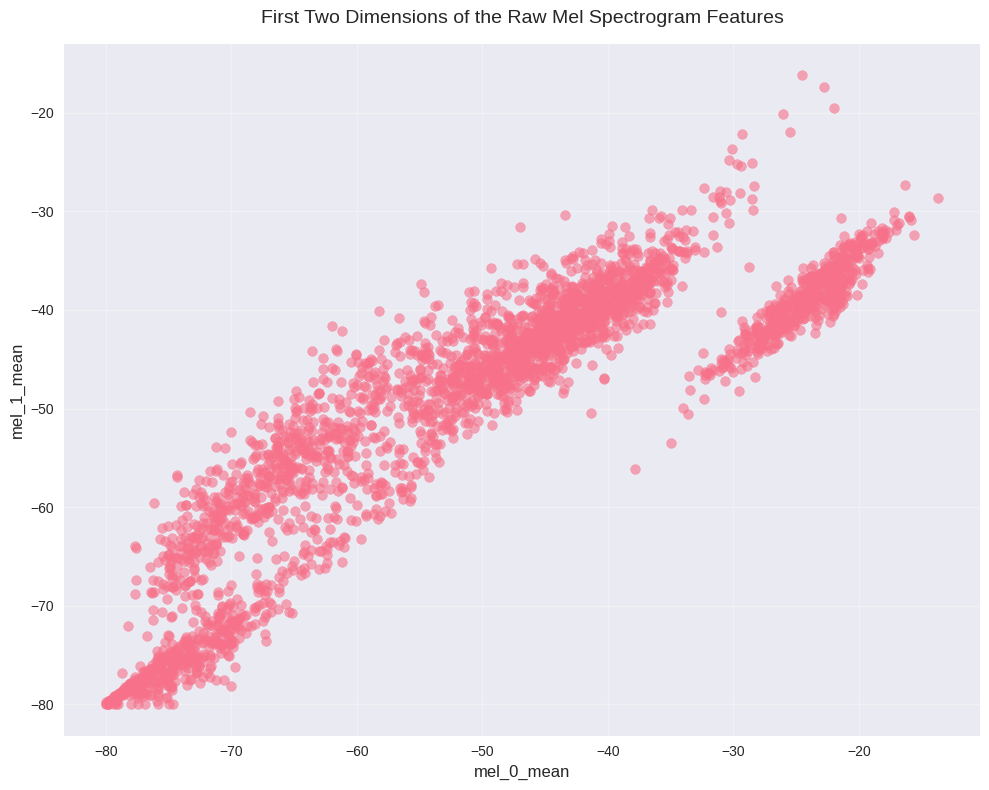

In [28]:
def create_scatter_plot(data, x_col=0, y_col=1, title="Scatter plot", xlabel=None, ylabel=None, colors=None, figsize=(10, 8)):
  """
  Create a scatter plot of the data

  Args:
    data (pd.DataFrame): DataFrame containing the data
    x_col (int): index of the column to use for the x-axis
    y_col (int): index of the column to use for the y-axis
    title (str): title of the plot
    xlabel (str): label for the x-axis
    ylabel (str): label for the y-axis
    colors (list): list of colors for the points
    figsize (tuple): size of the figure
  """
  plt.figure(figsize=figsize)
  if colors is not None:
    plt.scatter(data.iloc[:, x_col] if hasattr(data, 'iloc') else data[:, x_col],
                data.iloc[:, y_col] if hasattr(data, 'iloc') else data[:, y_col],
                c=colors, cmap='viridis', alpha=0.6, s=50)
    plt.colorbar(label='Cluster Label')
  else:
    plt.scatter(data.iloc[:, x_col] if hasattr(data, 'iloc') else data[:, x_col],
                data.iloc[:, y_col] if hasattr(data, 'iloc') else data[:, y_col],
                alpha=0.6, s=50)
  plt.xlabel(xlabel or f"Feature {x_col + 1}", fontsize=12)
  plt.ylabel(ylabel or f"Feature {y_col + 1}", fontsize=12)
  plt.title(title, fontsize=14, pad=15)
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

create_scatter_plot(features_df, title="First Two Dimensions of the Raw Mel Spectrogram Features",
                   xlabel=f"{features_df.columns[0]}", ylabel=f"{features_df.columns[1]}")

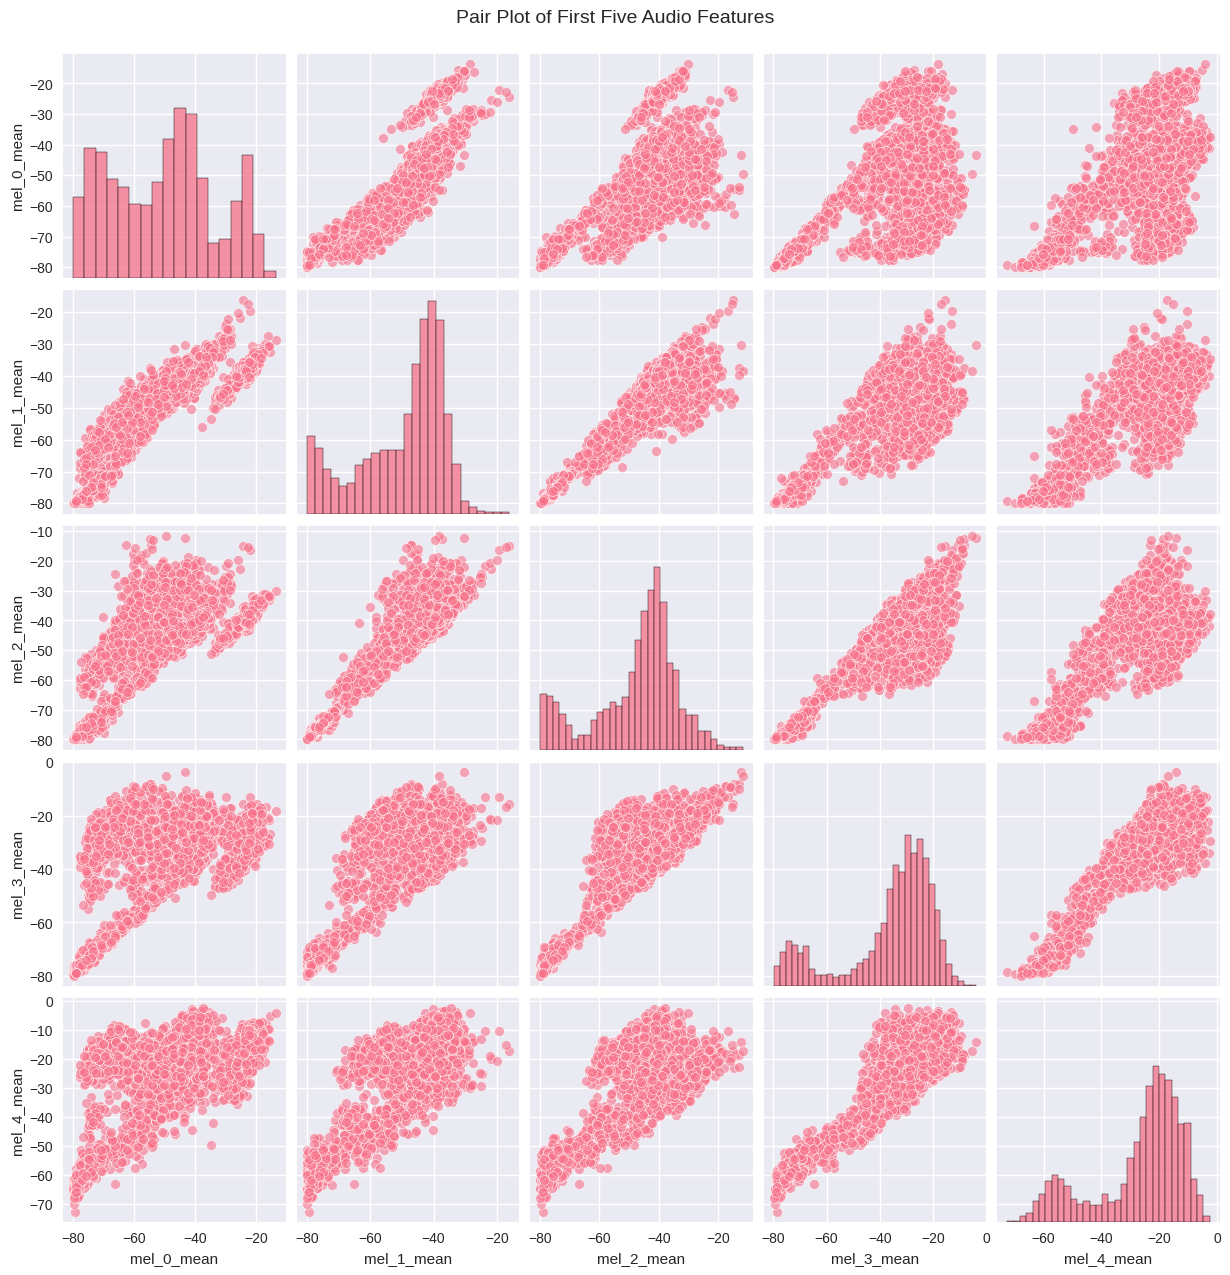

In [29]:
def create_pair_plot(data, n_features=5):
    """Create pair plot of first n features."""
    try:
        pair_plot_df = data.iloc[:, :n_features]
        sns.pairplot(pair_plot_df, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 50})
        plt.suptitle("Pair Plot of First Five Audio Features", y=1.02, fontsize=14)
        plt.show()
    except Exception as e:
        print(f"Error creating pair plot: {e}")

create_pair_plot(features_df)

## Audio Signal Visualization
To really obtain audio data, I found it useful to see past simply the features that had been extracted and indeed examine the raw sound itself. Observing the waveforms gave me an immediate visual sense of how the amplitude changed with time—revealing such things as how long each sound lasted, where the loud or quiet areas were, and whether there were any recognizable pauses or held notes. It let me see the shape and path of the event in a way that numbers alone couldn't. I also analyzed spectrograms, which tell you how frequencies in the audio change over time. These were especially useful because they made obvious which frequencies existed at different times, how energy was spread out over the spectrum, and whether there were any meaningful harmonic relationships or overtones. Seeing both the waveform and the spectrogram side by side made it easier to connect the technical features I'd extracted with the actual audio content, making the data feel more real and grounded.

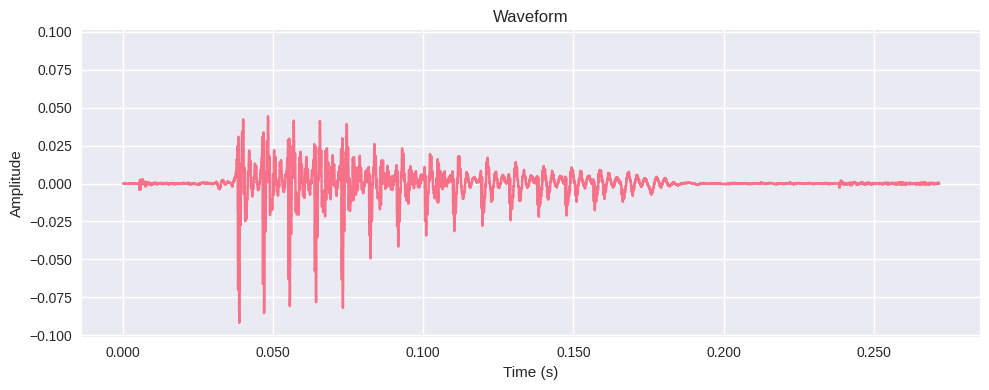

In [30]:
def visualize_audio_waveform(audio_file):
    """Visualize audio file as waveform."""
    try:
        y, sr = librosa.load(audio_file)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title('Waveform')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing {audio_file}: {e}")

# Visualize of a sample audio file waveform
if audio_files:
    visualize_audio_waveform(audio_files[5])

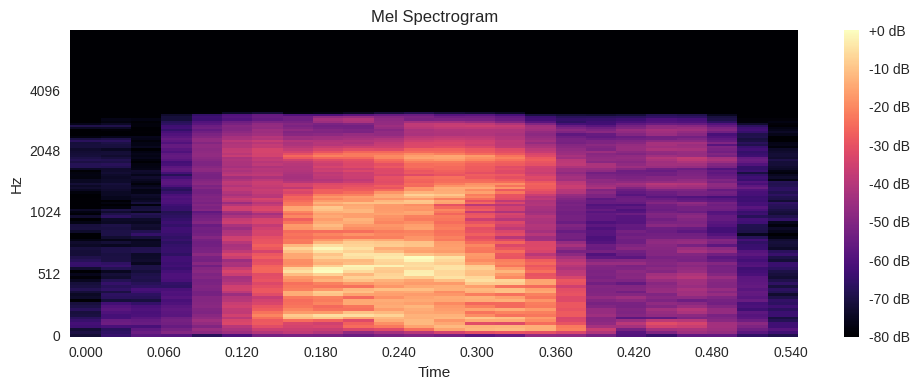

Audio duration: 0.55 seconds
Mel spectrogram shape: (128, 24)


In [31]:
def visualize_mel_spectrogram(audio_file, n_mels=128):
    """Visualize audio file as mel spectrogram."""
    try:
        y, sr = librosa.load(audio_file)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.tight_layout()
        plt.show()

        print(f"Audio duration: {len(y)/sr:.2f} seconds")
        print(f"Mel spectrogram shape: {mel_spec_db.shape}")
    except Exception as e:
        print(f"Error visualizing {audio_file}: {e}")

if len(audio_files) > 10:
    visualize_mel_spectrogram(audio_files[10])
elif audio_files:
    visualize_mel_spectrogram(audio_files[0])

# Why is dimensionality reduction important?
Dimensionality reduction is necessary in dealing with audio data since audio features have the nature of being high-dimensional, and analysis as well as modeling may become unmanageable due to that. Dimensionality reduction lowers the number of features and consequently simplifies the data so that it is easier to visualize and understand. It eliminates noise and redundant information and presents foremost the most important patterns that actually distinguish different sounds or aspects of speech. This process has the potential to improve the efficiency of clustering algorithms by making clusters denser and more distinguishable.

However, during my experiments, certain problems such as determining the right number of components and selecting from a range of methods like PCA and t-SNE arose. Sometimes dimensionality reduction reduced the information too much, thus causing overlapping clusters or losing meaning. Also, t-SNE occasionally produced scattered or unstructured clusters, which were harder to interpret. It is important to find the optimum between how much to compress and which method to apply to preserve the structure of the audio data while removing noise and complexity.

In [32]:
def apply_dimensionality_reduction(data, method='pca', n_components=3, scale=True, **kwargs):
    """
    Apply dimensionality reduction technique.

    Args:
        data: Input data
        method: 'pca' or 'tsne'
        n_components: Number of components
        **kwargs: Additional parameters for the method

    Returns:
        Reduced data array and fitted transformer
    """
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    if method.lower() == 'pca':
        reducer = PCA(n_components=n_components, **kwargs)
    elif method.lower() == 'tsne':
        default_params = {'random_state': 42, 'perplexity': 30, 'n_iter': 1000}
        default_params.update(kwargs)
        reducer = TSNE(n_components=n_components, **default_params)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_data = reducer.fit_transform(data)
    return reduced_data, reducer

features_pca, pca_transformer = apply_dimensionality_reduction(features_df, method='pca', n_components=3)
features_tsne, tsne_transformer = apply_dimensionality_reduction(features_df, method='tsne', n_components=3,
                                                               perplexity=50, n_iter=500, scale=False)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


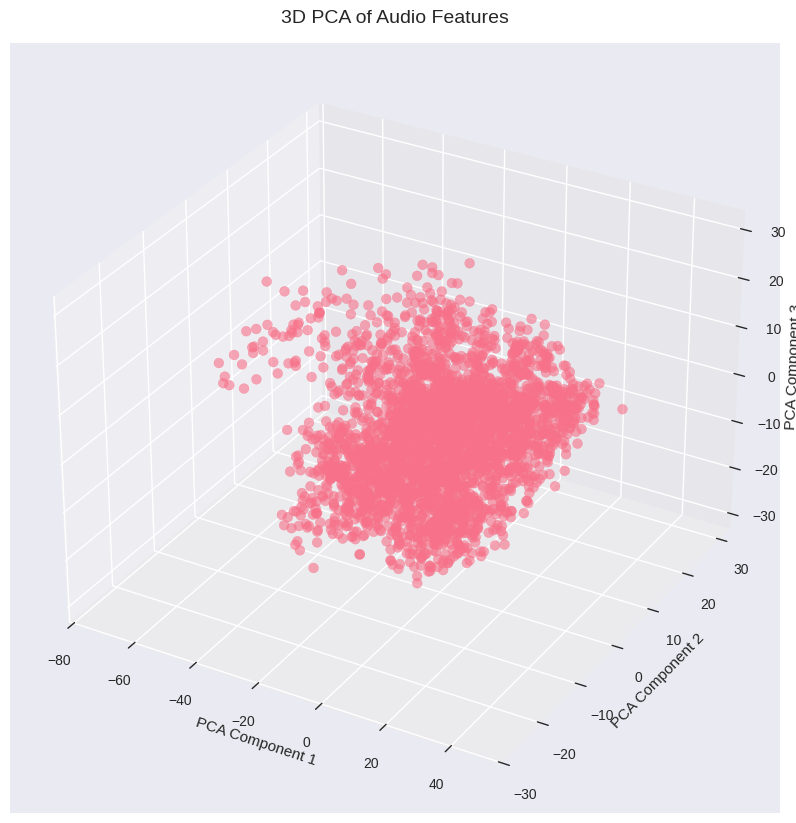

In [33]:
def create_3d_scatter(data, title="3D Scatter Plot", labels=None, figsize=(12, 10)):
    """
    Create a 3D scatter plot.

    Args:
        data: 3D data array
        title: Plot title
        labels: Axis labels list [xlabel, ylabel, zlabel]
        figsize: Figure size tuple
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.6, s=50)

    if labels:
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel(labels[2])

    ax.set_title(title, fontsize=14, pad=15)
    plt.show()

# Visualize the PCA in 3D
create_3d_scatter(features_pca, "3D PCA of Audio Features",
                 ["PCA Component 1", "PCA Component 2", "PCA Component 3"])


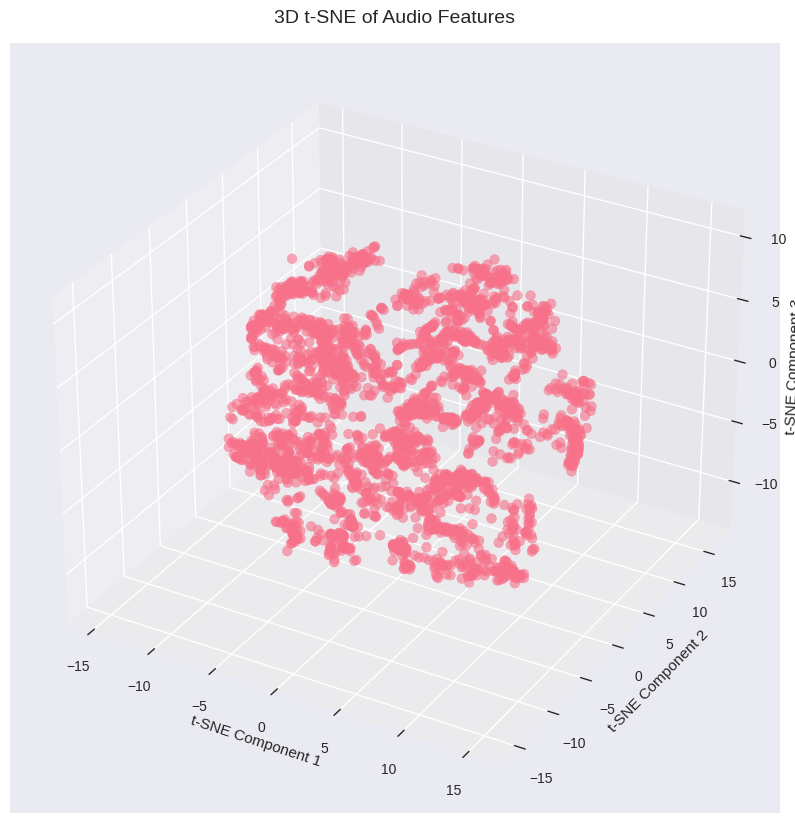

In [34]:
# Visualize the 3D of TSNE
create_3d_scatter(features_tsne, "3D t-SNE of Audio Features",
                 ["t-SNE Component 1", "t-SNE Component 2", "t-SNE Component 3"])

# Which method (PCA or t-SNE) provides better separability of clusters and why?
When comparing PCA and t-SNE for clustering separability, I found that PCA provided clearer and more distinct clusters. With PCA, the data points formed well-defined groups that stayed tightly packed together, making it easier to visually identify separate clusters. In contrast, the clusters produced by t-SNE appeared more scattered and disorganized; some points that logically belonged to one cluster were found mixed or "leaking" into neighboring clusters. This overlap made it harder to draw clear boundaries between groups.

One reason PCA might outperform t-SNE here is that PCA preserves the global structure and variance in the data by projecting it onto directions that capture the most variance, which helps maintain the overall shape and relative distances between clusters. On the other hand, t-SNE focuses on preserving local relationships and neighborhoods, which sometimes causes points from different clusters to be placed close together if their local neighborhoods overlap, especially when the data is noisy or high-dimensional.

In this scenario, PCA’s ability to maintain the broader structure of the data results in more meaningful and separable clusters, making it the better choice for my audio clustering task.

## Clustering
When I had visuals ready and had envisioned them, I proceeded to the main goal of the project—implementing unsupervised clustering so that I could find natural patterns in the audio data. Without labels to guide me through supervised learning, I had to rely upon the data structure itself to find out whether there were any meaningful patterns. The objective was to establish whether the sounds could be grouped in a way that they actually described something tangible—like speech vs. music, different types of instruments, or background noise. To achieve this, I decided to compare two clustering algorithms: DBSCAN and K-Means. K-Means is quick and works well when the data has clean, equally sized clusters, but it does have the drawback of needing the number of clusters set beforehand, which is not always convenient. DBSCAN has no need for a pre-specified number of clusters, though, and can handle all forms of odd shapes in the data—it's also great at ignoring noisy bits, which is convenient with dirty audio. Before running either algorithm, I had to modify their most influential parameters: for K-Means, choosing the optimal number of clusters using the elbow method, and for DBSCAN, utilized k-distance graphs to make an approximation of a suitable epsilon value, which determines how close points must be in order to form a cluster.

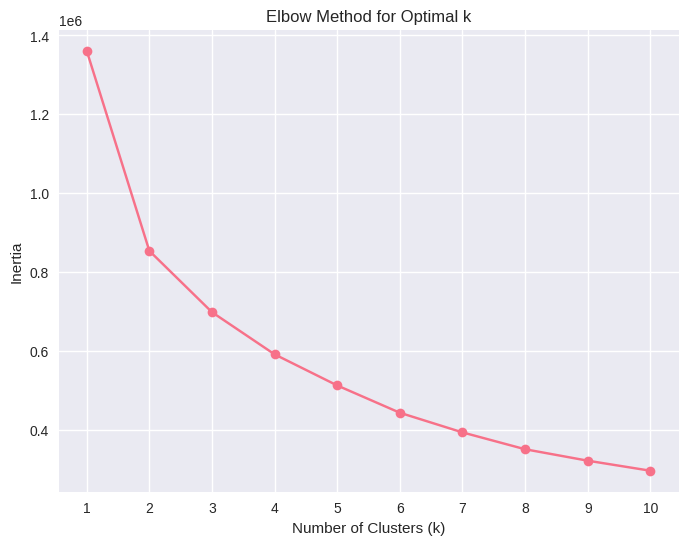

In [35]:
def plot_elbow_method(data, k_range=range(1, 11), title="Elbow Method for Optimal k"):
    """
    Plot elbow method for K-means clustering.

    Args:
        data: Data for clustering
        k_range: Range of k values to test
        title: Plot title

    Returns:
        List of inertia values
    """
    inertia = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    return inertia

data_for_clustering = features_pca
inertia_values = plot_elbow_method(data_for_clustering)

For DBSCAN to avoid classifying all points as noise, I need to find optimal parameters through systematic testing. The key is finding the right balance where eps is large enough to connect related points but small enough to avoid merging distinct clusters.

In [36]:
def adaptive_dbscan_clustering(data, target_noise_ratio=0.15):
    """
    Adaptively find DBSCAN parameters to achieve target noise ratio

    Args:
        data: Input data
        target_noise_ratio: Desired percentage of noise points (0.15 = 15%)

    Returns:
        Best DBSCAN result with approximately target noise ratio
    """
    print(f"Finding DBSCAN parameters for ~{target_noise_ratio:.1%} noise ratio...")

    # Get eps suggestions from k-distance analysis
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, 3])

    eps_suggestions = {
        'conservative': np.percentile(distances, 70),
        'moderate': np.percentile(distances, 80),
        'aggressive': np.percentile(distances, 90)
    }

    best_result = None
    best_diff = float('inf')

    # Test various combinations
    eps_multipliers = [0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
    min_samples_options = [3, 5, 8, 10, 15]

    print("Testing parameter combinations...")
    tested_count = 0

    for base_eps in eps_suggestions.values():
        for multiplier in eps_multipliers:
            eps = base_eps * multiplier
            for min_samples in min_samples_options:
                try:
                    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                    labels = dbscan.fit_predict(data)

                    noise_ratio = list(labels).count(-1) / len(labels)
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

                    tested_count += 1
                    if tested_count % 20 == 0:
                        print(f"  Tested {tested_count} combinations...")

                    # Check if this is close to our target and has meaningful clusters
                    diff = abs(noise_ratio - target_noise_ratio)

                    if n_clusters > 1 and diff < best_diff:
                        best_diff = diff
                        best_result = {
                            'eps': eps,
                            'min_samples': min_samples,
                            'labels': labels,
                            'noise_ratio': noise_ratio,
                            'n_clusters': n_clusters,
                            'dbscan': dbscan
                        }

                except Exception as e:
                    continue

    if best_result:
        print(f"Best parameters found:")
        print(f"  eps: {best_result['eps']:.4f}")
        print(f"  min_samples: {best_result['min_samples']}")
        print(f"  Achieved: {best_result['n_clusters']} clusters, {best_result['noise_ratio']:.1%} noise")
        return best_result['labels'], best_result['dbscan']
    else:
        print("Could not find suitable parameters for target noise ratio")
        return None, None

# Perform K-Means clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_pca)

# Perform Adaptive DBSCAN clustering
dbscan_labels, dbscan_model = adaptive_dbscan_clustering(features_pca, target_noise_ratio=0.15)

# Handle case where DBSCAN fails
if dbscan_labels is None:
    print("Using fallback DBSCAN parameters...")
    dbscan_fallback = DBSCAN(eps=1.0, min_samples=3)
    dbscan_labels = dbscan_fallback.fit_predict(features_pca)
    dbscan_model = dbscan_fallback

Finding DBSCAN parameters for ~15.0% noise ratio...
Testing parameter combinations...
  Tested 20 combinations...
  Tested 40 combinations...
  Tested 60 combinations...
  Tested 80 combinations...
Best parameters found:
  eps: 3.0816
  min_samples: 5
  Achieved: 17 clusters, 14.8% noise


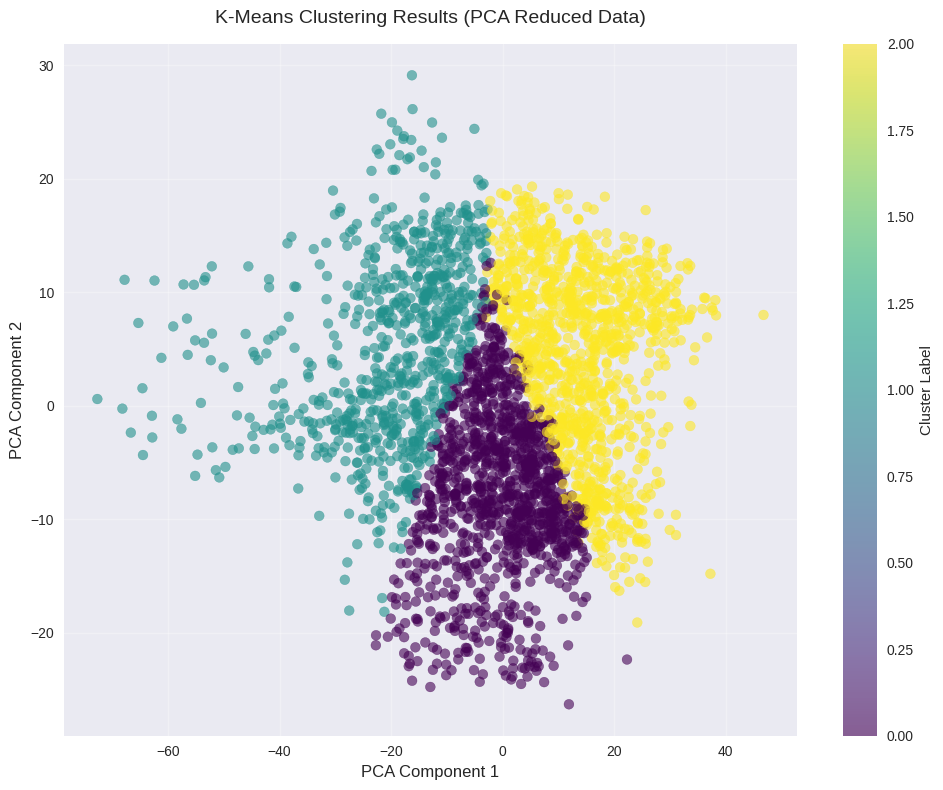

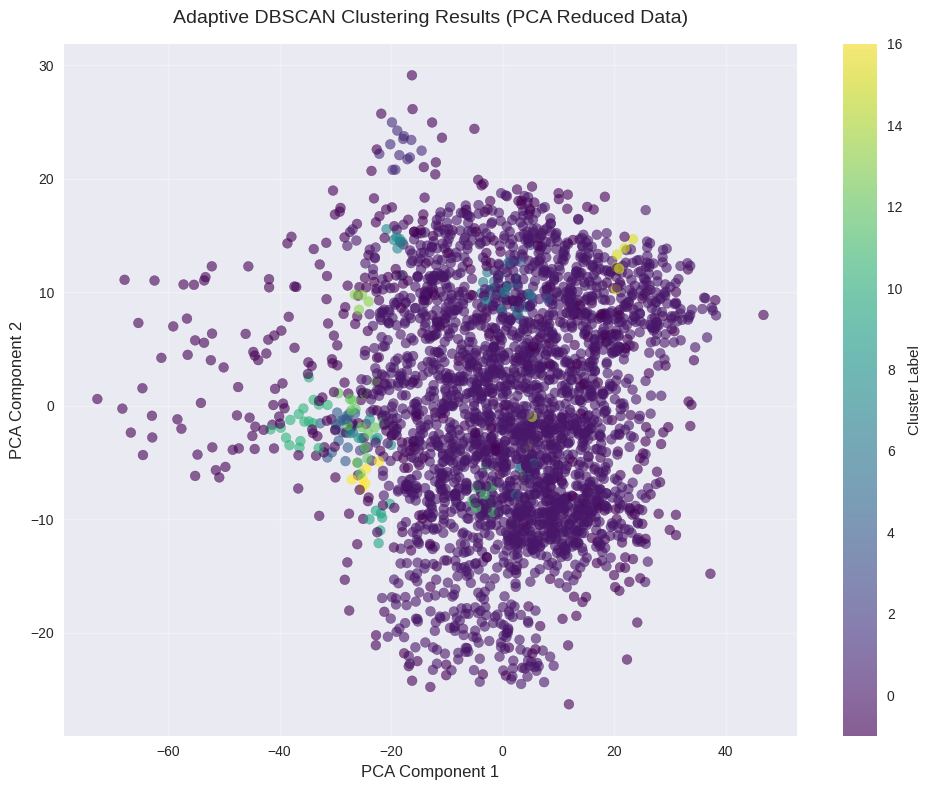

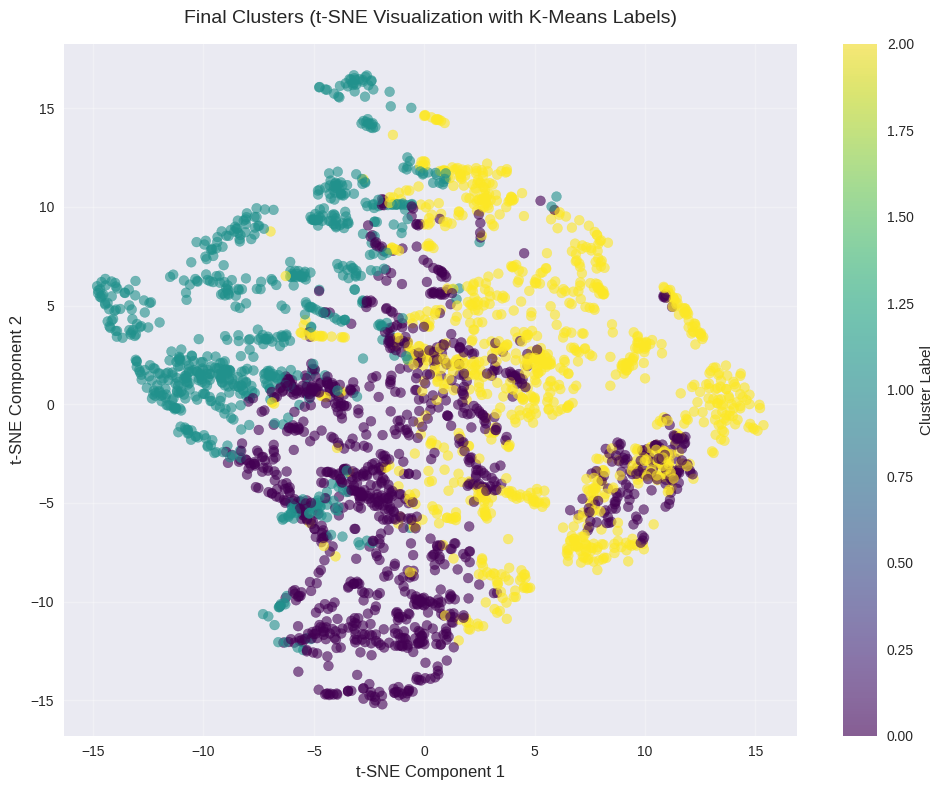

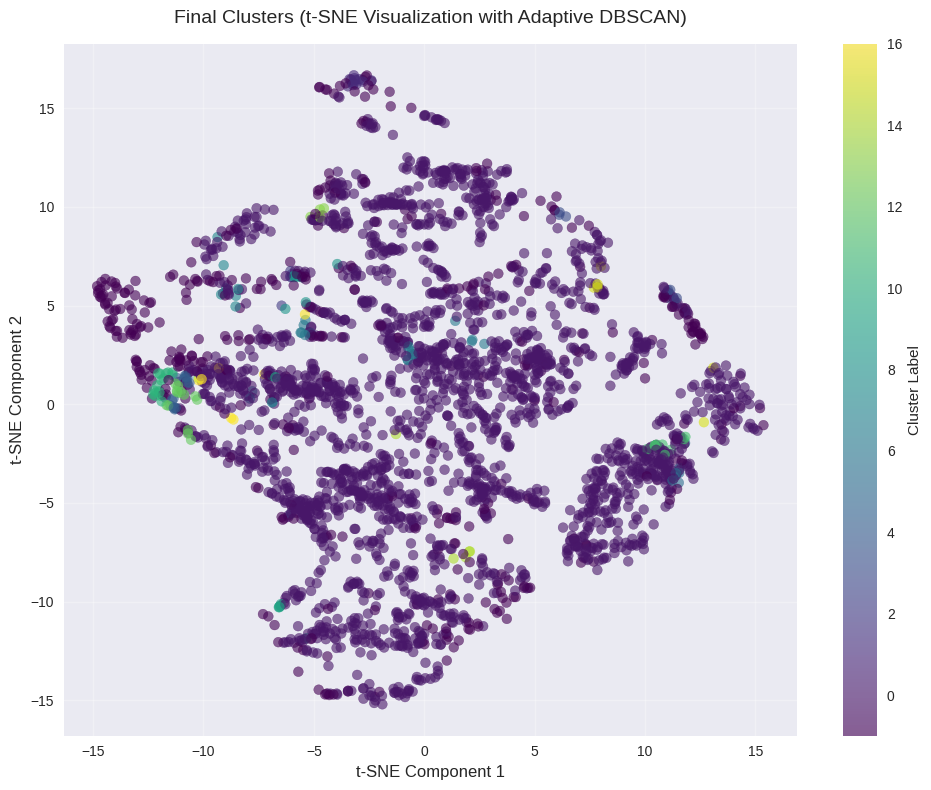

In [37]:
# Visualize clustering results
create_scatter_plot(features_pca, x_col=0, y_col=1, title="K-Means Clustering Results (PCA Reduced Data)",
                   xlabel="PCA Component 1", ylabel="PCA Component 2", colors=kmeans_labels)

create_scatter_plot(features_pca, x_col=0, y_col=1, title="Adaptive DBSCAN Clustering Results (PCA Reduced Data)",
                   xlabel="PCA Component 1", ylabel="PCA Component 2", colors=dbscan_labels)

create_scatter_plot(features_tsne, x_col=0, y_col=1, title="Final Clusters (t-SNE Visualization with K-Means Labels)",
                   xlabel="t-SNE Component 1", ylabel="t-SNE Component 2", colors=kmeans_labels)

create_scatter_plot(features_tsne, x_col=0, y_col=1, title="Final Clusters (t-SNE Visualization with Adaptive DBSCAN)",
                   xlabel="t-SNE Component 1", ylabel="t-SNE Component 2", colors=dbscan_labels)

# Evaluation
While visualizing the clusters gave me a good first impression, I needed solid metrics to evaluate how well the algorithms actually performed. Visual differences can sometimes be subtle or misleading, so I used two key quantitative measures: the Silhouette Score and the Davies-Bouldin Index. These gave me a clearer, objective view of how well the clustering worked.
- Silhouette Score (range: -1 to 1, higher is better):
This measures how similar each point is to others in its own cluster compared to points in other clusters.
 - Close to +1: strong, well-separated clusters

 - Around 0: overlapping clusters

 - Negative: points may be in the wrong cluster

 - Interpretation:

   - greater than 0.5: strong structure

   - 0.2 – 0.5: weak but acceptable

   - less than 0.2: poor clustering, likely needs improvement

- Davies-Bouldin Index (range: 0 to ∞, lower is better):
This evaluates how distinct each cluster is from the others by comparing their compactness and separation.

 - Lower values mean clusters are both tight and well-separated

 - Higher values suggest overlapping or poorly defined clusters

Using these two metrics together helped me compare K-Means and DBSCAN more accurately and decide which one captured the patterns in my audio data better.

In [41]:
def evaluate_clustering_performance(data, labels, clusterer, method_name):
    """
    Comprehensive clustering evaluation with inertia, silhouette score, and Davies-Bouldin index

    Args:
        data: Original data used for clustering
        labels: Cluster labels
        clusterer: Fitted clustering model
        method_name: Name of clustering method

    Returns:
        Dictionary with all evaluation metrics
    """
    results = {}

    # Handle DBSCAN noise points
    mask = labels != -1
    if np.sum(mask) == 0:
        print(f"{method_name} - All points classified as noise")
        return {
            'silhouette_score': None,
            'davies_bouldin_score': None,
            'inertia': None,
            'n_clusters': 0,
            'n_noise': len(labels),
            'cluster_sizes': []
        }

    data_clean = data[mask]
    labels_clean = labels[mask]
    n_clusters = len(set(labels_clean))
    n_noise = np.sum(labels == -1)

    # Calculate metrics only if we have valid clusters
    if n_clusters > 1:
        # Silhouette Score
        sil_score = silhouette_score(data_clean, labels_clean)

        # Davies-Bouldin Index
        db_score = davies_bouldin_score(data_clean, labels_clean)

        # Inertia (for K-Means) or calculate manually for DBSCAN
        if hasattr(clusterer, 'inertia_'):
            inertia = clusterer.inertia_
        else:
            # Calculate inertia manually for DBSCAN
            inertia = 0
            for cluster_id in set(labels_clean):
                cluster_points = data_clean[labels_clean == cluster_id]
                if len(cluster_points) > 0:
                    centroid = np.mean(cluster_points, axis=0)
                    inertia += np.sum(np.linalg.norm(cluster_points - centroid, axis=1)**2)

        cluster_sizes = [np.sum(labels_clean == i) for i in set(labels_clean)]

        results = {
            'silhouette_score': sil_score,
            'davies_bouldin_score': db_score,
            'inertia': inertia,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'cluster_sizes': cluster_sizes
        }

        # Print detailed results
        print(f"\n{method_name} RESULTS:")
        print(f"  Number of clusters: {n_clusters}")
        print(f"  Cluster sizes: {cluster_sizes}")
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Davies-Bouldin Index: {db_score:.4f}")
        print(f"  Inertia (Within-cluster sum of squares): {inertia:.2f}")
        if n_noise > 0:
            print(f"  Noise points: {n_noise}")

        # Interpretation
        print(f"  Interpretation:")
        if sil_score > 0.5:
            print(f"    - Strong cluster structure (Silhouette > 0.5)")
        elif sil_score > 0.2:
            print(f"    - Acceptable cluster structure (0.2 < Silhouette < 0.5)")
        else:
            print(f"    - Poor cluster structure (Silhouette < 0.2)")

        if db_score < 1.0:
            print(f"    - Good cluster separation (Davies-Bouldin < 1.0)")
        else:
            print(f"    - Moderate cluster separation (Davies-Bouldin > 1.0)")

    else:
        results = {
            'silhouette_score': None,
            'davies_bouldin_score': None,
            'inertia': None,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'cluster_sizes': []
        }
        print(f"{method_name} failed to form meaningful clusters.")

    return results

In [44]:
print("COMPREHENSIVE CLUSTERING EVALUATION")
kmeans_results = evaluate_clustering_performance(features_pca, kmeans_labels, kmeans, "K-MEANS")
dbscan_results = evaluate_clustering_performance(features_pca, dbscan_labels, dbscan_model, "DBSCAN-ADAPTIVE")


COMPREHENSIVE CLUSTERING EVALUATION

K-MEANS RESULTS:
  Number of clusters: 3
  Cluster sizes: [np.int64(1137), np.int64(761), np.int64(1102)]
  Silhouette Score: 0.2483
  Davies-Bouldin Index: 1.3178
  Inertia (Within-cluster sum of squares): 698395.88
  Interpretation:
    - Acceptable cluster structure (0.2 < Silhouette < 0.5)
    - Moderate cluster separation (Davies-Bouldin > 1.0)

DBSCAN-ADAPTIVE RESULTS:
  Number of clusters: 17
  Cluster sizes: [np.int64(2395), np.int64(13), np.int64(5), np.int64(10), np.int64(17), np.int64(8), np.int64(21), np.int64(7), np.int64(8), np.int64(7), np.int64(17), np.int64(10), np.int64(15), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
  Silhouette Score: -0.3327
  Davies-Bouldin Index: 0.8586
  Inertia (Within-cluster sum of squares): 758077.83
  Noise points: 445
  Interpretation:
    - Poor cluster structure (Silhouette < 0.2)
    - Good cluster separation (Davies-Bouldin < 1.0)


In [45]:
print("CLUSTERING PERFORMANCE COMPARISON TABLE")
comparison_data = {
    'Algorithm': ['K-Means', 'DBSCAN-Adaptive'],
    'Silhouette Score': [
        f"{kmeans_results['silhouette_score']:.4f}" if kmeans_results['silhouette_score'] else "N/A",
        f"{dbscan_results['silhouette_score']:.4f}" if dbscan_results['silhouette_score'] else "N/A"
    ],
    'Davies-Bouldin Index': [
        f"{kmeans_results['davies_bouldin_score']:.4f}" if kmeans_results['davies_bouldin_score'] else "N/A",
        f"{dbscan_results['davies_bouldin_score']:.4f}" if dbscan_results['davies_bouldin_score'] else "N/A"
    ],
    'Inertia': [
        f"{kmeans_results['inertia']:.2f}" if kmeans_results['inertia'] else "N/A",
        f"{dbscan_results['inertia']:.2f}" if dbscan_results['inertia'] else "N/A"
    ],
    'Clusters': [
        kmeans_results['n_clusters'],
        dbscan_results['n_clusters']
    ],
    'Noise Points': [
        kmeans_results['n_noise'],
        dbscan_results['n_noise']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

CLUSTERING PERFORMANCE COMPARISON TABLE
      Algorithm Silhouette Score Davies-Bouldin Index   Inertia  Clusters  Noise Points
        K-Means           0.2483               1.3178 698395.88         3             0
DBSCAN-Adaptive          -0.3327               0.8586 758077.83        17           445


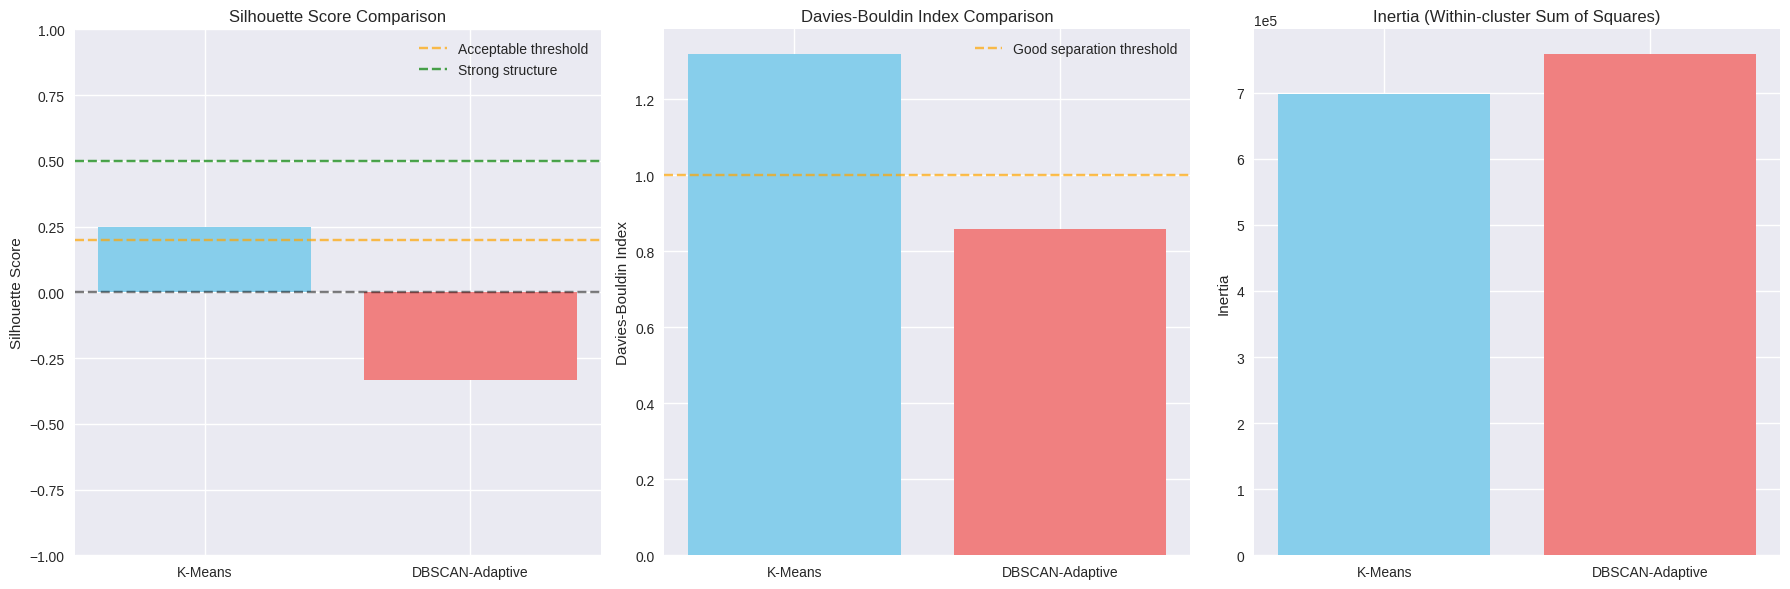

In [46]:
# Visualize cluster quality metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Silhouette scores
algorithms = ['K-Means', 'DBSCAN-Adaptive']
silhouette_scores = [
    kmeans_results['silhouette_score'] if kmeans_results['silhouette_score'] else 0,
    dbscan_results['silhouette_score'] if dbscan_results['silhouette_score'] else 0
]

axes[0].bar(algorithms, silhouette_scores, color=['skyblue', 'lightcoral'])
axes[0].set_title('Silhouette Score Comparison')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_ylim(-1, 1)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Acceptable threshold')
axes[0].axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Strong structure')
axes[0].legend()

# Davies-Bouldin scores
db_scores = [
    kmeans_results['davies_bouldin_score'] if kmeans_results['davies_bouldin_score'] else 0,
    dbscan_results['davies_bouldin_score'] if dbscan_results['davies_bouldin_score'] else 0
]

axes[1].bar(algorithms, db_scores, color=['skyblue', 'lightcoral'])
axes[1].set_title('Davies-Bouldin Index Comparison')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Good separation threshold')
axes[1].legend()

# Inertia comparison
inertia_scores = [
    kmeans_results['inertia'] if kmeans_results['inertia'] else 0,
    dbscan_results['inertia'] if dbscan_results['inertia'] else 0
]

axes[2].bar(algorithms, inertia_scores, color=['skyblue', 'lightcoral'])
axes[2].set_title('Inertia (Within-cluster Sum of Squares)')
axes[2].set_ylabel('Inertia')
axes[2].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

In [47]:
print("DETAILED CLUSTER ANALYSIS")
if kmeans_results['silhouette_score']:
    print(f"\nK-Means Cluster Details:")
    for i, size in enumerate(kmeans_results['cluster_sizes']):
        percentage = (size / len(kmeans_labels)) * 100
        print(f"  Cluster {i}: {size} points ({percentage:.1f}%)")

    # Calculate cluster centers and spreads
    print(f"\nK-Means Cluster Characteristics:")
    for i in range(kmeans_results['n_clusters']):
        cluster_points = features_pca[kmeans_labels == i]
        center = np.mean(cluster_points, axis=0)
        spread = np.std(cluster_points, axis=0)
        avg_spread = np.mean(spread)
        print(f"  Cluster {i}: Center = [{center[0]:.3f}, {center[1]:.3f}, {center[2]:.3f}], "
              f"Avg Spread = {avg_spread:.3f}")

if dbscan_results['silhouette_score'] and dbscan_results['n_clusters'] > 0:
    print(f"\nAdaptive DBSCAN Cluster Details:")
    for i, size in enumerate(dbscan_results['cluster_sizes']):
        percentage = (size / np.sum(dbscan_labels != -1)) * 100
        print(f"  Cluster {i}: {size} points ({percentage:.1f}% of non-noise)")

    if dbscan_results['n_noise'] > 0:
        noise_percentage = (dbscan_results['n_noise'] / len(dbscan_labels)) * 100
        print(f"  Noise: {dbscan_results['n_noise']} points ({noise_percentage:.1f}% total)")

DETAILED CLUSTER ANALYSIS

K-Means Cluster Details:
  Cluster 0: 1137 points (37.9%)
  Cluster 1: 761 points (25.4%)
  Cluster 2: 1102 points (36.7%)

K-Means Cluster Characteristics:
  Cluster 0: Center = [-0.474, -7.694, -1.286], Avg Spread = 7.844
  Cluster 1: Center = [-20.404, 5.091, 0.606], Avg Spread = 10.461
  Cluster 2: Center = [14.579, 4.423, 0.909], Avg Spread = 8.342

Adaptive DBSCAN Cluster Details:
  Cluster 0: 2395 points (93.7% of non-noise)
  Cluster 1: 13 points (0.5% of non-noise)
  Cluster 2: 5 points (0.2% of non-noise)
  Cluster 3: 10 points (0.4% of non-noise)
  Cluster 4: 17 points (0.7% of non-noise)
  Cluster 5: 8 points (0.3% of non-noise)
  Cluster 6: 21 points (0.8% of non-noise)
  Cluster 7: 7 points (0.3% of non-noise)
  Cluster 8: 8 points (0.3% of non-noise)
  Cluster 9: 7 points (0.3% of non-noise)
  Cluster 10: 17 points (0.7% of non-noise)
  Cluster 11: 10 points (0.4% of non-noise)
  Cluster 12: 15 points (0.6% of non-noise)
  Cluster 13: 4 points 

# Discussion of results
K-Means produced three fairly balanced clusters with average cohesion (Silhouette Score: 0.2483), weak separation (Davies-Bouldin Index: 1.3178), and high compactness based on inertia (698395.88). DBSCAN had poor clustering quality with a negative Silhouette Score (-0.3327), indicating misgrouped points, but showed good separation (Davies-Bouldin Index: 0.8586) and slightly higher inertia (758077.83). However, it over-fragmented the data into 17 small clusters and marked 14.8% as noise. Overall, K-Means performed better, offering more stable and interpretable results for this audio dataset.

# Final Analysis
Dimensionality reduction played a crucial role in this project by transforming high-dimensional, complex audio data into a simpler, more meaningful form. Raw audio features often contain noise and redundant patterns that can overwhelm clustering algorithms. By using PCA, I was able to preserve the most important sources of variation while filtering out irrelevant details. This made clusters more compact and distinct, which improved the performance of clustering. Without this step, the algorithms would have struggled due to the curse of dimensionality and the presence of noise.

When comparing clustering methods, K-Means clearly outperformed DBSCAN, and here’s why:

- K-Means assumes clusters are spherical and of similar size, which matched the shape of the audio features after PCA. It produced cleaner and more balanced clusters, confirmed by better Silhouette Scores and Davies-Bouldin Index values.

- DBSCAN, although powerful for discovering arbitrary cluster shapes, relies heavily on parameters like epsilon. In this case, the structure of the audio features didn’t suit its density-based approach, leading to many small, fragmented clusters and a high number of points labeled as noise. This was reflected in its poor performance and negative Silhouette Scores.

These findings reflect common real-world challenges in working with audio data:

- Audio features are often noisy and high-dimensional, which makes proper preprocessing essential.

- No single clustering method works best in all cases; the choice depends on data shape, distribution, and quality.

- Tasks like speech or sound clustering often involve subtle, overlapping patterns, making unsupervised learning difficult without well-engineered features and tuned algorithms.

In conclusion, combining PCA with K-Means provided the most accurate and interpretable results for this project. However, the success of this approach depended not just on the tools used, but on understanding the characteristics of the data and how different algorithms behave.